# Machine Learning: Dimensionality Reduction

Material for the [2018 Asterics and Obelics School](https://indico.in2p3.fr/event/16864/): [Table of Contents](Contents.ipynb)

Content is maintained on [github](https://github.com/Asterics2020-Obelics/School2018/tree/master/machinelearning) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

![sponsor-logos](img/sponsor-logos.png)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

We will use a new sklearn module:

In [2]:
from sklearn import decomposition

Some of the code below generates [annoying warnings](https://github.com/mwaskom/seaborn/issues/1392). You usually want to be aware of warnings, especially when they give advance notice of something that will break in a future version of a package you depend on.

However, to keep a clean notebook, you can always silence specific expected warnings like this:

In [3]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [4]:
from mls import plot_image

## Dimensionality of Data

We call the number of features (columns) in a dataset its **dimensionality** $D$. In order to learn how different features are related, we need enough samples to get a complete picture.

For example, imagine splitting each feature at its median value then, at a minimum, we would like to have at least one sample in each of the resulting $2^D$ bins.  This is a very low bar and only requires 8 samples with D=3, but requires $2^{30} > 1$ billion samples with D=30!

To get a feel for how well sampled your dataset is, compare your actual number of samples $N$ with the target $2^D$.

Our image dataset with $D=256$ is heavily undersampled:

In [5]:
df_img = pd.read_hdf('data/sources_img.hf5')
N, D = df_img.shape
print(f'Dataset has {N} samples with {D} features.')
print(f'2^D is {2 ** D}.')

Dataset has 50000 samples with 256 features.
2^D is 115792089237316195423570985008687907853269984665640564039457584007913129639936.


## Dimensionality Reduction

Dimensionality reduction algorithms attempt to discover a subspace of undersampled data that best explains the data. The features in this subspace are often referred to as **latent variables**.

The notion of "explaining the data" is poorly defined, with different choice leading to different algorithms.

Dimensionality reduction is an unsupervised learning method (like clustering).

The key idea of dimensionality reduction is that not all features carry equal information.

As an extreme example, consider the following 2D data which is effectively 1D since one feature has a constant value (zero):

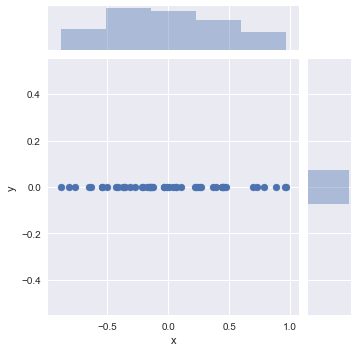

In [6]:
gen = np.random.RandomState(seed=123)
data = pd.DataFrame()
data['x'] = gen.uniform(-1, +1, 50)
data['y'] = np.zeros_like(data['x'])
sns.jointplot('x', 'y', data, stat_func=None, size=5);

Is this data is still 1D if we add some small scatter in the 2nd dimension?

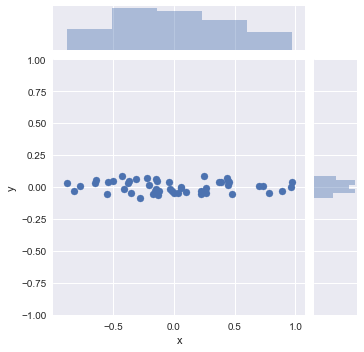

In [7]:
# Add some scatter in the 2nd dimension.
data['y'] = gen.normal(scale=0.04, size=len(data))
sns.jointplot('x', 'y', data, stat_func=None, size=5);
plt.ylim(-1, +1);

The scatter adds new information in a second dimension, but we can approximately ignore it under two assumptions:
- The relative scaling of the x and y columns is meaningful (which is almost certainly not true if these columns have different dimensions - recall our earlier comments about normalizing data).
- The origin of the scatter is due to measurement error or some other un-informative process.

What if we also rotate x and y so the data has some size in dimensions?

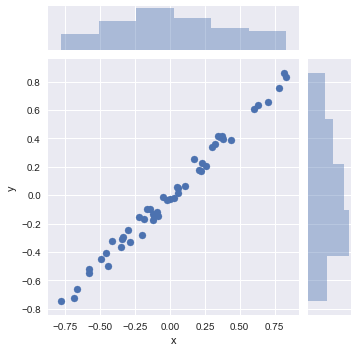

In [8]:
theta = np.deg2rad(30.)
rotated = data.copy()
rotated['x'] = np.cos(theta) * data['x'] - np.sin(theta) * data['y']
rotated['y'] = np.cos(theta) * data['x'] + np.sin(theta) * data['y']
sns.jointplot('x', 'y', rotated, stat_func=None, size=5);

The rotation does not change the effective dimensionality of the data.

Finally, what if we put the data along a curve instead of a line?

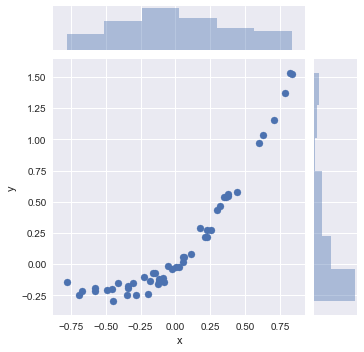

In [9]:
nonlinear = rotated.copy()
nonlinear['y'] = rotated['y'] + rotated['x'] ** 2
sns.jointplot('x', 'y', nonlinear, stat_func=None, size=5);

A non-linear relationship between x and y also does not change the underlying dimensionality since we could, in principle, perform a non-linear change of coordinates to undo it.  However, we can expect that non-linear relationships will be harder to deal with than linear ones.

## Linear Decompositions

The goal of a linear decomposition is to automatically identify linear combinations of the original features that account for most of the variance in the data. Note that we are using variance (spread) as a proxy for "useful information", so it is essential that the relative normalization of our features is meaningful.

If we represent our data with the $N\times D$ matrix $X$, then a linear decomposition can be represented as the following matrix multiplication:
![Linear Decomposition](img/LinearDecomposition.png)

The $N\times d$ matrix $Y$ is a reduced representation of the original data $X$, with $d < D$ new features that are linear combinations of the original $D$ feature.  We call the new features "latent variables", since they were already present in $X$ but only implicitly.

The $d\times D$ matrix $M$ specifies the relationship between the old and new features: each column is unit vector for a new feature in terms of the old features.  Note that $M$ is not square when $d < D$ and unit vectors are generally not mutually orthogonal (except for the PCA method).

A linear decomposition is not exact (hence the $\simeq$ above) and there is no "best" prescription for determining $Y$ and $M$. Below we review the most popular prescriptions implemented in the [sklearn.decomposition](http://scikit-learn.org/stable/modules/decomposition.html) module (links are to wikipedia and sklearn documentation):

| Method | sklearn |
| ------ | ------- |
| [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) | [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) |
| [Factor Analysis](https://en.wikipedia.org/wiki/Factor_analysis) | [FactorAnalysis](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html) |
| [Non-negative Matrix Factorization](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) | [NMF](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) |
| [Independent Component Analysis](https://en.wikipedia.org/wiki/Independent_component_analysis) | [FastICA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html) |

All methods require that you specify the desired number of latent variables $d$ (but you can easily experiment with different values) and are called using (method = PCA, FactorAnalysis, NMF, FastICA):
```
fit = decomposition.method(n_components=d).fit(X)
```
The resulting decomposition into $Y$ and $M$ is given by:
```
M = fit.components_
Y = fit.transform(X)
```
except for FastICA, where `M = fit.mixing_.T`.

A useful visualization of how effectively the latent variables capture the interesting information in the original data is to reconstruct the original data using:
$$
X' = Y M
$$
and compare rows (samples) of $X'$ with the original $X$.  They will not agree exactly, but if the differences seem uninteresting (e.g., look like noise), then the dimensionality reduction was successful and you can use $Y$ instead of $X$ for subsequent analysis.

We will use the function below to demonstrate each of these in turn (but you can ignore its details unless you are interested):

In [10]:
def demo(method='PCA', d=2, data=df_img, npix=16):
    
    X = data.values
    N, D = X.shape
    
    if method is 'NMF':
        # All data must be positive.
        assert np.all(X >= 0)
        # Analysis includes the mean.
        mu = np.zeros(D)
    else:
        mu = np.mean(X, axis=0)
    fit = eval('decomposition.' + method)(n_components=d).fit(X)
    
    # Check that decomposition has the expected shape.
    if method is 'FastICA':
        M = fit.mixing_.T
    else:
        M = fit.components_
    assert M.shape == (d, D)
    Y = fit.transform(X)
    assert Y.shape == (N, d)
    
    # Reconstruct X - mu from the fitted Y, M.
    Xr = np.dot(Y, M) + mu
    assert Xr.shape == X.shape
    
    # Compare a few samples from X and Xr.
    fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(12, 6))
    for col in range(4):
        img = df_img.iloc[col].values
        rec = Xr[col]
        for row, image in enumerate((img, rec)):
            plot_image(image, ax=axes[row, col])
    plt.tight_layout()
    return Y

### Principal Component Analysis

PCA is the most commonly used method for dimensionality reduction. The decomposition is uniquely specified by the following prescription (more details [here](https://en.wikipedia.org/wiki/Principal_component_analysis#Computing_PCA_using_the_covariance_method)):
- Find the eigenvectors and eigenvalues of $C = X^T X / (N-1)$ which is an [empirical estimate](https://en.wikipedia.org/wiki/Covariance#Calculating_the_sample_covariance) of the covariance matrix for the data.
- Construct $M$ out of eigenvectors ordered by decreasing eigenvalue (which are all positive) and solve the resulting linear equations for $Y$. At this point the decomposition is exact with $d = D$.
- Shrink $Y$ and $M$ from $D$ to $d$ rows ($M$) or columns ($Y$), which makes the decomposition approximate while discarding the least amount of variance in the original data (which we use as a proxy for "useful information").

![PCA decomposition](img/PCAdecomposition.png)

The full $M$ matrix (before shrinking $D\rightarrow d$) is orthogonal $M^T = M^{-1}$ and satisfies $X^T X = M^T \Lambda M$, where $\Lambda$ is a diagonal matrix of the decreasing eigenvalues. Note that this description glosses over some details.

The resulting latent variables are *statistically uncorrelated* (which is a weaker statement than *statistically independent* -- see below), i.e., the [correlation coefficients](https://en.wikipedia.org/wiki/Correlation_coefficient) between different columns of $Y$ are approximately zero:
$$
\rho(j,k) = \frac{Y_j\cdot Y_k}{|Y_j|\,|Y_k|} \simeq 0 \; .
$$

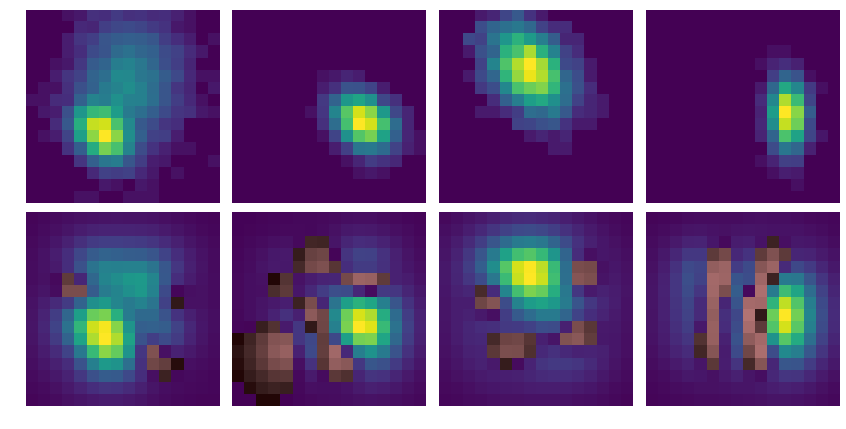

In [11]:
demo('PCA', d=16); # 16x compression from D=256

The top row shows the original binned data and the bottom row shows the PCA reconstruction. Although the original data is always positive (yellow-green), the reconstruction has some negative values (brown).

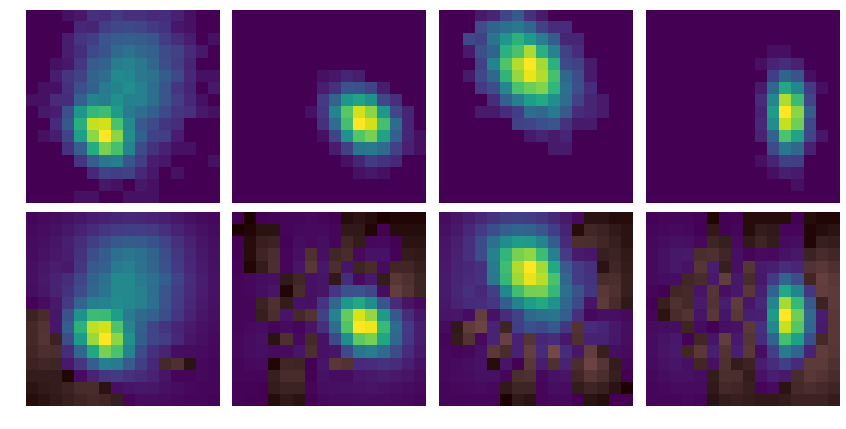

In [12]:
demo('PCA', d=64); # 4x compression

Note that the reconstructed samples are in some sense *better* than the originals since the original Poisson shot noise was associated with a small eigenvalue that was trimmed!

### Factor Analysis

Factor analysis (FA) often produces similar results to PCA, but is conceptually different.

Both PCA and FA implicitly assume that the data is approximately sampled from a multidimensional Gaussian. PCA then finds the principal axes of the the resulting multidimensional ellipsoid, while FA is based on a model for how the original data is generated from the latent variables.  Specifically, FA seeks latent variables that are uncorrelated unit Gaussians and allows for different noise levels in each feature, while assuming that this noise is uncorrelated with the latent variables.  PCA does not distinguish between "signal" and "noise" and implicitly assumes that the large eigenvalues are more signal-like and small ones more noise-like.

When the FA assumptions about the data (of Gaussian latent variables with uncorrelated noise added) are correct, it is certaintly the better choice, in principle.  In practice, FA decomposition is more expensive and requires an iterative Expectation-Maximization (EM) algorithm.  You should normally try both, but prefer the simpler PCA when the results are indistinguishable.

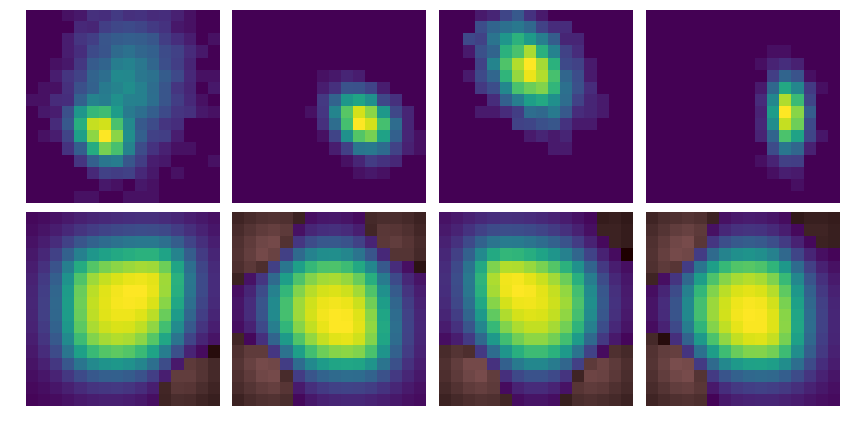

In [13]:
demo('FactorAnalysis', d=4); # 16x compression from D=256

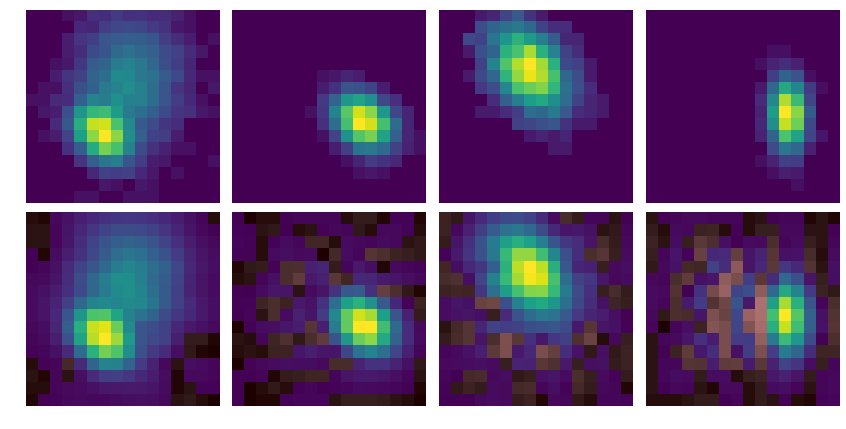

In [14]:
demo('FactorAnalysis', d=64); # 4x compression from D=256

### Non-negative Matrix Factorization

Most linear factorizations start by centering each feature about its mean over the samples:
$$
X_{ij} \rightarrow X_{ij} - \mu_i \quad , \quad \mu_i \equiv \frac{1}{N} \sum_i\, X_{ij} \; .
$$
As a result, latent variables are equally likely to be positive or negative.

Non-negative matrix factorization (NMF) assumes that the data are a (possibly noisy) linear superposition of different components, which is often a good description of data resulting from a physical process.  For example, the spectrum of a galaxy is a superposition of the spectra of its constituent stars, and the spectrum of a radioactive sample is a superposition of the decays of its constituent unstable isotopes.

These processes can only **add** data, so the elements of $Y$ and $M$ should all be $\ge 0$ if the latent variables describe additive mixtures of different processes.  The NMF factorization guarantees that both $Y$ and $M$ are positive, and requires that the input $X$ is also positive.  However, there is no guarantee that the non-negative latent variables found by NMF are due to physical mixtures.

Since NMF does not internally subtract out the means $\mu_i$, it generally needs an additional component to model the mean.

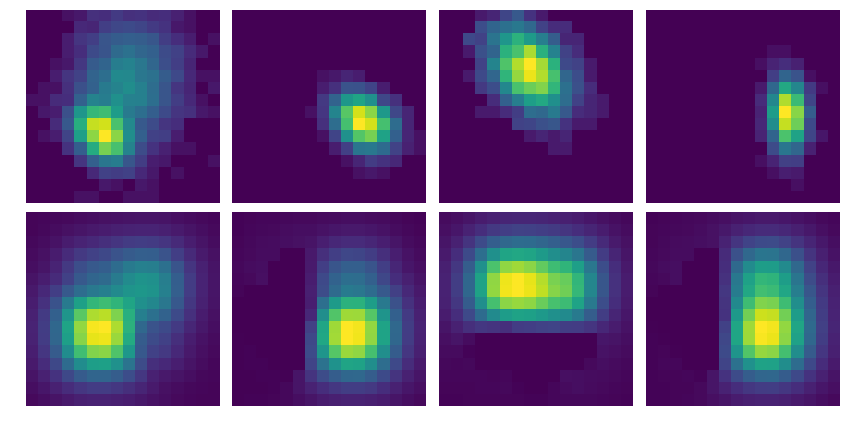

In [15]:
demo('NMF', d=4); # 16x compression from D=256

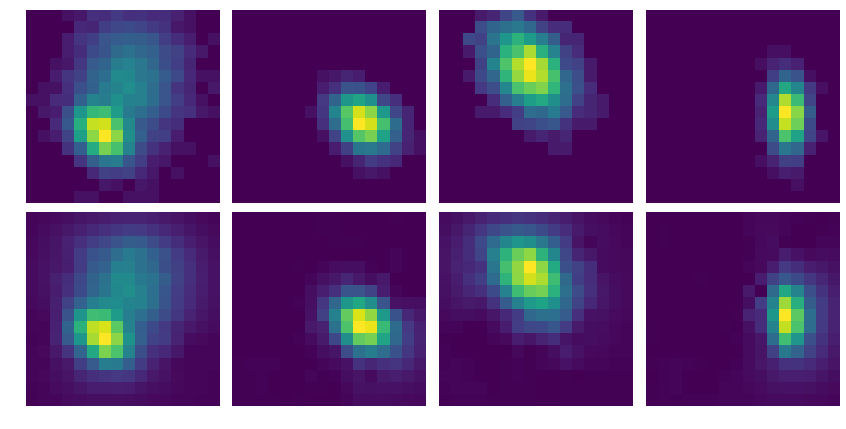

In [16]:
demo('NMF', d=64); # 4x compression from D=256

Note how the reconstructed images all all non-negative, by construction. NMF is quite slow with this many components.

### Independent Component Analysis

The final linear decomposition we will consider is ICA, where the goal is to find latent variables $Y$ that are *statistically independent*, which is a stronger statement that the *statistically uncorrelated* guarantee of PCA. The basic idea is that the joint probability of a sample occuring with latent variables $y_1, y_2, y_3, \ldots$ can be factorized into independent probabilities for each component:
$$
P(y_1, y_2, y_3, \ldots) = P(y_1) P(y_2) P(y_3) \ldots
$$

ICA has some inherent ambiguities: both the ordering and scaling of latent variables is arbitrary, unlike with PCA. However, in practice, samples reconstructed with ICA often look similar to PCA and FA reconstructions.

ICA is also used for [blind signal separation](https://en.wikipedia.org/wiki/Blind_signal_separation), where usually $d = N$.

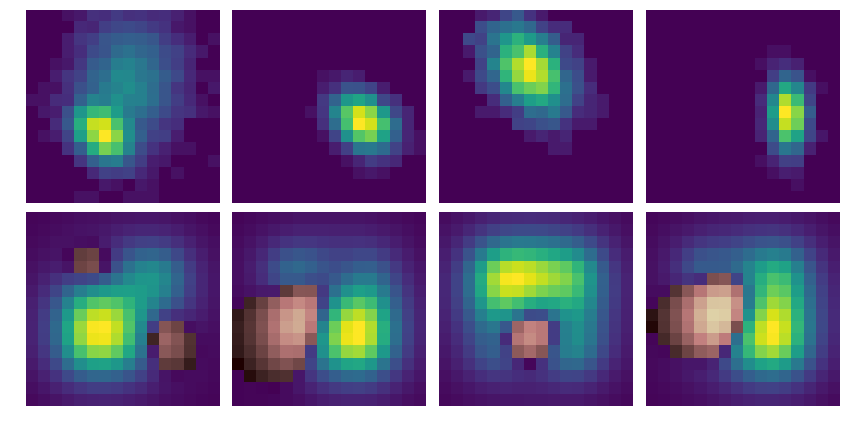

In [17]:
demo('FastICA', d=4); # 16x compression from D=256

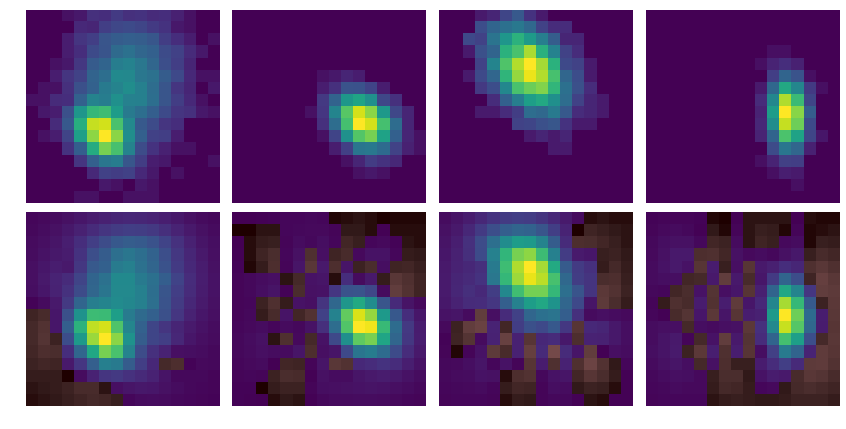

In [18]:
demo('FastICA', d=64); # 4x compression from D=256

### Dealing with Noisy or Missing Data

The linear algorithms presented above work fine with noisy data, but have no way to take advantage of data that includes its own estimate of the noise level.  In the most general case, each element of the data matrix $X$ has a corresponding RMS error estimate $\delta X$, with values $\rightarrow\infty$ used to indicate missing data. In practice, it is convenient to replace $\delta X$ with a matrix of weights $W$ where zero values indicate missing data. For data with Gaussian errors, $X_{ij} \pm \delta X_{ij}$, the appropriate weight is usually the *inverse variance* $W_{ij} = \delta X_{ij}^{-2}$.

The [wpca package](https://github.com/jakevdp/wpca) implements two different schemes to incorporate weights into PCA, which give similar results to each other.  Both schemes are used almost identically to sklearn PCA, but with an additional `weights` argument (method = `wpca.WPCA` or `wpca.EMPCA`):
```
fit = method(n_components=d).fit(X, weights=W)
```
Unfortunately, `wpca.WPCA` expects `weights=np.sqrt(W)` but this might be [fixed soon](https://github.com/jakevdp/wpca/issues/2).

To study these schemes, we will assign weights assuming that each value $X_{ij}$ is the result of a Poisson signal superimposed on a constant (subtracted) background level $B$, so has inverse variance $W_{ij} = \left(B + X_{ij}\right)^{-1}$.

In [19]:
import wpca

In [20]:
def weighted_pca(d, B=100, missing_frac=None, data=df_img, npix=16, seed=123):
    gen = np.random.RandomState(seed=seed)
    X = data.values.copy()
    N, D = X.shape
    # Calculate inverse variances assuming Poisson fluctuations in B + X.
    W = 1 / np.sqrt(B + X)
    # Remove some fraction of data from each sample, if requested.
    if missing_frac:
        assert 0 < missing_frac < 0.5
        num_missing = int(round(missing_frac * D))
        missing = gen.randint(D, size=num_missing * N)
        for i in range(N):
            idx = missing[num_missing * i: num_missing * (i + 1)]
            X[i, idx] = 0.
            W[i, idx] = 0.
    # Perform the fit.
    fit = wpca.WPCA(n_components=d).fit(X, weights=W)
    Y = fit.transform(X, weights=W)
    Xr = fit.inverse_transform(Y)

    # Compare a few samples from X and Xr.
    fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(12, 6))
    for col in range(4):
        img = X[col]
        rec = Xr[col]
        for row, image in enumerate((img, rec)):
            plot_image(image, ax = axes[row, col])
    plt.tight_layout()

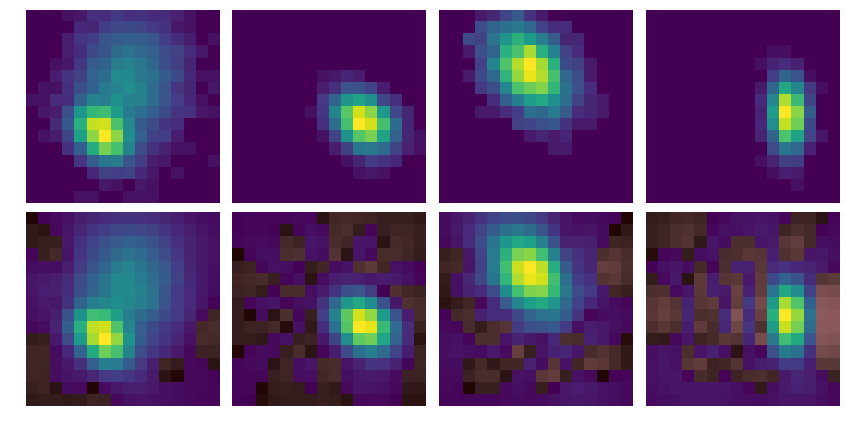

In [21]:
weighted_pca(d=64) # using weights with no missing data

Externally provided uncertainties put more weight on explaining pixels with large values, and correspondingly less weight on on the low-statistics tails.

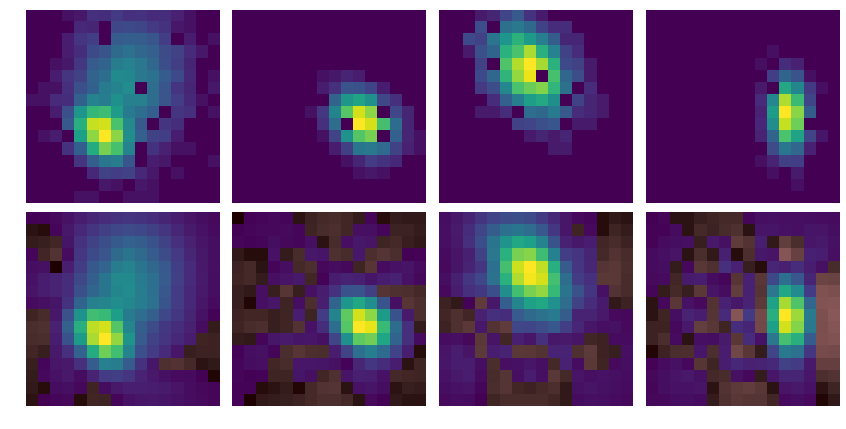

In [22]:
weighted_pca(d=64, missing_frac=0.1) # using weights with 10% missing data

With 10% of the data missing (and assigned zero weight), the reconstructed quality is barely degraded. Note how this allows us to make a sensible guess at the missing data! (statisticians call this [imputation](https://en.wikipedia.org/wiki/Imputation_(statistics)).

### Non-linear Dimensionality Reduction

The methods above find latent variables that are linear functions of the original features. 

There are also non-linear methods:
 - When they work, the results are spectacular.
 - However, they are generally [very sensitive to your choice of hyperparameters](https://github.com/scikit-learn/scikit-learn/issues/10530).
 - I recommend that you always start with a linear method and only prefer a non-linear model if it has clearly better performance and gives consistent and robust results.
 
For an overview of non-linear methods, see [here](https://github.com/dkirkby/MachineLearningStatistics/blob/master/notebooks/Nonlinear.ipynb). One key idea is the "kernel trick", which is also central to the power of neural networks.

### Model-Driven Compression

Most dimensionality reduction methods assume that variance is a good proxy for "information". However, when you have a good generative model of your data, you can do much better. In particular, there is an optimal compression algorithm for data generated by a model with $n$ parameters that will reduce your whole dataset down to $n$ numbers! See this [2018 paper](https://doi.org/10.1093/mnras/sty819) for details.

### Acknowledgement:
**H2020-Astronomy ESFRI and Research Infrastructure Cluster (Grant Agreement number: 653477).**